In [16]:
# importing the libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25, wandbactive=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  if (wandbactive==1):
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

### hyperparameters and general parameters
n_epochs=10000
batch_size=128
lr=1e-4
z_dim=200
device='cuda' #GPU

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35

wandbact=1

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login(key='069ce6ae7096893483afb1cd97b044b83fa2d821')

In [18]:
%%capture
experiment_name = wandb.util.generate_id()

myrun=wandb.init(
    project="wgan",
    group=experiment_name,
    config={
        "optimizer":"adam",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128
    }
)

config=wandb.config

In [19]:
class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(

            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), 
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1),
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1),
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), 
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), 
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), 
            nn.Tanh() 
    )


  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1, 1)  
    return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
   return torch.randn(num, z_dim, device=device) 

In [20]:
class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
     
      nn.Conv2d(3, d_dim, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*2), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*4), 
      nn.LeakyReLU(0.2),
              
      nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*8), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), 
      nn.InstanceNorm2d(d_dim*16), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16, 1, 4, 1, 0), 

    )


  def forward(self, image):
   
    crit_pred = self.crit(image) 
    return crit_pred.view(len(crit_pred),-1) 

In [21]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias,0)

    if isinstance(m,nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias,0)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/img_align_celeba.zip' -d '/content/data/celeba'

In [22]:
path = 'data/celeba'

class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes=[size, size]
    items, labels=[],[]

    for data in os.listdir(path)[:lim]:
  
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels


  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # (178,218)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128 # from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]

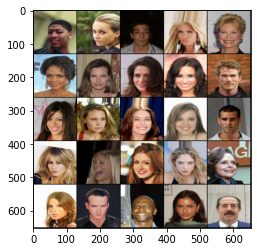

In [23]:
## Dataset
data_path='./data/celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

## DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt= torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

if (wandbact==1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x,y=next(iter(dataloader))
show(x)

In [24]:
root_path='./drive/MyDrive/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()      
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()      
  }, f"{root_path}C-{name}.pkl")
  
  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

In [ ]:
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs= len(real) #128
    real=real.to(device)

    ### CRITIC
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise=gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True)
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss+=crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses+=[mean_crit_loss]

    ### GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses+=[gen_loss.item()]

    ### Stats  
   
    if (wandbact==1):
      wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss':mean_crit_loss, 'Gen loss': gen_loss})

    if cur_step % save_step == 0 and cur_step > 0:
      print("Saving checkpoint: ", cur_step, save_step)
      save_checkpoint("latest")

    if (cur_step % show_step == 0 and cur_step > 0):
      show(fake, wandbactive=1, name='fake')
      show(real, wandbactive=1, name='real')

      gen_mean=sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-150,150)
      plt.legend()
      plt.show()
    
    cur_step+=1